# Importing Libraries

In [441]:
import tweepy
from tweepy import OAuthHandler,Stream,API
from tweepy.streaming import StreamListener
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import re
import twitter_creds
from twitter_creds import *
import re
import json
from collections import Counter
import pandas as pd
from langdetect import detect
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
from wordcloud import WordCloud
import numpy as np

# Function for api authentication

In [54]:

def Authentication() : 
    auth = OAuthHandler(CONSUMER_KEY,CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN,ACCESS_TOKEN_SECRET)
    api = tweepy.API(auth)
    return api
    

# Function for creating a StreamListener

In [59]:
class MyStreamListener(StreamListener):
    def on_data(self,data):
        try:
            with open('tweet.json','a') as ff:
                ff.write(data)
            return True
        except BaseException as e:
            print("Error on data : %s" % str(e))
            return True
    def on_error(self,status):
        print(status)
        return True         
    
    

# Instantiation of the Class Objects

In [60]:
api = Authentication()
ListenObj = MyStreamListener()
my_stream = Stream(api.auth,ListenObj)

# Twitter Handles to filter for

In [61]:
my_stream.filter(track=['generalelections2019','2019elections','GeneralElections2019','LokSabhaElections2019','Elections2019'],languages = ["en"],async=True)

Creating a list of dictionary

In [183]:
tweets = []
for line in open('tweet.json', 'r'):
    tweets.append(json.loads(line))

Creating a Dataframe

In [185]:
##df = pd.DataFrame.from_dict(tweets)
df = pd.DataFrame(columns = ['created_at','text','id','screen_name','location','followers_count','friends_count','favourites_count','statuses_count'])
for tweet in tweets:
    df.loc[-1] = (tweet['created_at'],tweet['text'],tweet['user']['id'],tweet['user']['screen_name'],tweet['user']['location'],
                            tweet['user']['followers_count'],tweet['user']['friends_count'],tweet['user']['favourites_count'],tweet['user']['statuses_count'])
    df.index = df.index + 1

In [444]:
##df['text'].str.replace(r'-', '-')
##df['text'].str.cat(sep=' ')
##df['text'].str[:10]
##df['text'].str.extract(r'(?P<letter>[ab])(?P<digit>\d)',expand=False)
len(tweets),len(df)

(5000, 5000)

# Feature Engineering

In [238]:
df['city'] = df['location'].str.strip().str.lower().str.split(',',expand=True)[0].str.split('/',expand=True)[0]

In [269]:
df['datetime'] = pd.to_datetime(df['created_at'])
df['date'] = df['datetime'].dt.date
df['time'] = df['datetime'].dt.time
df['day'] = df['datetime'].dt.weekday_name

In [295]:
df.sort_index(axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last', sort_remaining=True, by=None)

# Data Cleaning - Tweets

In [335]:
df['clean_text'] = df['text'].apply(lambda x : ' '.join (word for word in x.split(' ') if not re.search(r"(\||(\n)|(RT)|(http)|@|#)+",word) )).values

# Visualisation - Word Cloud

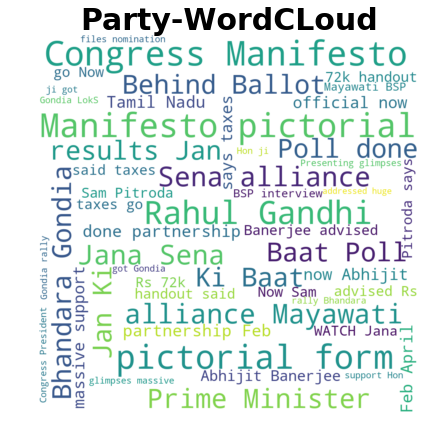

In [378]:
plt.figure(figsize = (7,7))
party_wordcloud = WordCloud(width=1000, height=1000, max_words=50,background_color='white',mode='RGB').generate(' '.join(df['clean_text']))
plt.imshow(party_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Party-WordCLoud',{'fontsize': 30,'fontweight' :'bold'})
plt.show()

# Creating a function for party Classification from the text.
It would return a dictionary object with the counts of BJP aligned and Congress Aligned keywords

In [385]:
def Party_classifier(sentense):
    bjp_count = 0
    cong_count = 0
    bjp_pool = ['bjp','namo','modiji','narendra','modi','amit shah','ji','bhartiya']
    cong_pool = ['rahul','gandhi','sam','sonia','gandhi','alliance','cong','congress','secular']
    for word in sentense.split(' '):
        if (word.lower() in bjp_pool):
            bjp_count += 1
        elif (word.lower() in cong_pool):
                cong_count += 1
    return({'bjp' : bjp_count, 'cong' : cong_count})

In [389]:
df['tweet_party'] = df['clean_text'].apply(lambda x : Party_classifier(x))

In [392]:
df['party'] = df['tweet_party'].apply(lambda x : 'bjp' if ( x['bjp'] > x['cong']) else 'congress' if ( x['bjp'] < x['cong']) else 'neutral' )

Creating two subsets for Dataframes one for each party

In [395]:
df_bjp = df[df.party == 'bjp']
df_congress = df[df.party == 'congress']

In [396]:
len(df_bjp),len(df_congress)

(859, 847)

# Creating Wordclouds for BJP and Congress tweets

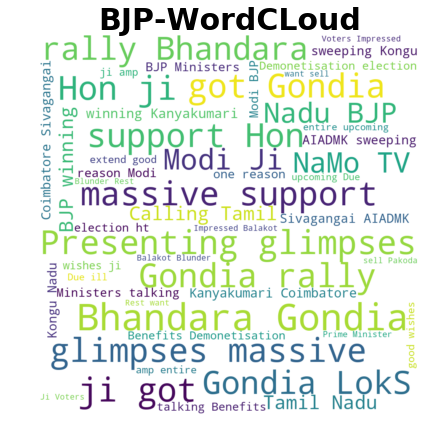

In [399]:
plt.figure(figsize = (7,7))
bjp_wordcloud = WordCloud(width=1000, height=1000, max_words=50,background_color='white',mode='RGB').generate(' '.join(df_bjp['clean_text']))
plt.imshow(bjp_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('BJP-WordCLoud',{'fontsize': 30,'fontweight' :'bold'})
plt.show()

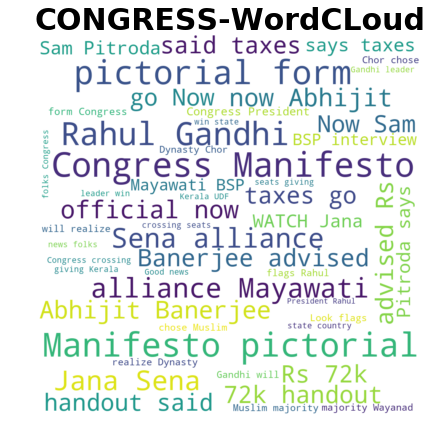

In [400]:
plt.figure(figsize = (7,7))
congress_wordcloud = WordCloud(width=1000, height=1000, max_words=50,background_color='white',mode='RGB').generate(' '.join(df_congress['clean_text']))
plt.imshow(congress_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('CONGRESS-WordCLoud',{'fontsize': 30,'fontweight' :'bold'})
plt.show()

# Sentiment Analysis of the tweets . Checking the Polarity.

In [436]:
df_bjp['sentiment'] =  df_bjp['clean_text'].apply(lambda x : sid.polarity_scores(x))
df_congress['sentiment'] =  df_congress['clean_text'].apply(lambda x : sid.polarity_scores(x))

In [437]:
df_bjp['neg'] = df_bjp['sentiment'].map(lambda x : x['neg'])
df_bjp['pos'] = df_bjp['sentiment'].map(lambda x : x['pos'])

In [438]:
df_congress['neg'] = df_congress['sentiment'].map(lambda x : x['neg'])
df_congress['pos'] = df_congress['sentiment'].map(lambda x : x['pos'])

In [439]:
df_congress['neg'] = df_congress['sentiment'].map(lambda x : x['neg'])
df_congress['pos'] = df_congress['sentiment'].map(lambda x : x['pos'])

In [425]:
df_bjp[['neg','pos']].head()

,neg,pos
34,0.000,0.144
43,0.000,0.144
45,0.000,0.207
56,0.000,0.144
66,0.161,0.000


In [440]:
df_congress[['neg','pos']].head()

,neg,pos
9,0.0,0.175
11,0.0,0.000
18,0.0,0.000
22,0.0,0.000
25,0.0,0.000


# Creating overall mood object which has average sentiments about each Party

In [442]:
overall_mood = {'bjp_neg' : np.average(df_bjp['neg']), 'bjp_pos' : np.average(df_bjp['pos']), 'congress_neg' : np.average(df_congress['neg']), 'congress_pos' : np.average(df_congress['pos'])}

In [443]:
overall_mood

{'bjp_neg': 0.052965075669383,
 'bjp_pos': 0.13064610011641442,
 'congress_neg': 0.011828807556080281,
 'congress_pos': 0.06470365997638725}

# Conclusion
1. As per the above results we see that, the voters are very assertive about admiring BJP , the positive score being much higher than any other category.
2. People are more vocal about criticizing BJP (neg score : 0.05) than Congress (neg score : 0.01)
3. Congress (pos score : .064) doesnt muster good support from its exponents as does BJP (pos score : .13)

To conclude, BJP has huge supporter base, but higher negative sentiments against it. On the other hand congress has lower support base and lower negative sentiments against it.

So the Focus here is Not the Congress Manifesto but reap the benefits of Anti-Incumbancy.

Finally, it remains to be seen, if the number of people carrying negative sentiments about BJP outshine the number of people who are BJP supporters.
